# FastF1 Race Position Prediction

## Project Overview

This notebook uses the **FastF1** library to build a machine learning model that predicts driver finishing positions in Formula 1 races using only **pre-race information**:

- Qualifying positions
- Practice session performance  
- Weather conditions
- Grid starting positions
- Team and track data

We'll explore both classical ML (Linear Regression, Random Forest, XGBoost) and deep learning (PyTorch) approaches.

---

## Phase 1: Setup and Data Access

First, we'll import all necessary libraries and configure FastF1's caching system.

In [97]:
# Core data science libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# FastF1 for F1 data
import fastf1
from fastf1 import plotting

# Machine Learning - Classical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Machine Learning - XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Install with: pip install xgboost")

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Utilities
import warnings
warnings.filterwarnings('ignore')

print(f"FastF1 version: {fastf1.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")

FastF1 version: 3.6.1
PyTorch version: 2.9.0
XGBoost available: True


### Configure FastF1 Cache

FastF1 downloads timing and telemetry data from the FIA's API. To avoid re-downloading data every time, we'll enable caching.

In [38]:
# Enable caching to speed up data loading
cache_dir = './fastf1_cache'
fastf1.Cache.enable_cache(cache_dir)

print(f"Cache enabled at: {cache_dir}")
print("Data will be downloaded once and reused on subsequent runs.")

Cache enabled at: ./fastf1_cache
Data will be downloaded once and reused on subsequent runs.


### Test FastF1 Connection

Let's load a single race session to verify everything is working correctly.

In [ ]:
# Load the 2024 Bahrain Grand Prix Race session as a test
# This will download data on first run (may take a minute)
session = fastf1.get_session(2024, 'Bahrain', 'R')
session.load()

print(f"✓ Successfully loaded: {session.event['EventName']} - {session.name}")
print(f"  Date: {session.date}")
print(f"  Circuit: {session.event['Location']}")
print(f"\nSession loaded successfully! FastF1 is working.")

### Quick Exploration

Let's take a quick look at what data is available in a race session.

In [6]:
# View the race results
results = session.results
print("Race Results Preview:")
print(results[['DriverNumber', 'Abbreviation', 'TeamName', 'GridPosition', 'Position', 'Points']].head(10))

Race Results Preview:
   DriverNumber Abbreviation         TeamName  GridPosition  Position  Points
1             1          VER  Red Bull Racing           1.0       1.0    26.0
11           11          PER  Red Bull Racing           5.0       2.0    18.0
55           55          SAI          Ferrari           4.0       3.0    15.0
16           16          LEC          Ferrari           2.0       4.0    12.0
63           63          RUS         Mercedes           3.0       5.0    10.0
4             4          NOR          McLaren           7.0       6.0     8.0
44           44          HAM         Mercedes           9.0       7.0     6.0
81           81          PIA          McLaren           8.0       8.0     4.0
14           14          ALO     Aston Martin           6.0       9.0     2.0
18           18          STR     Aston Martin          12.0      10.0     1.0


---

## Phase 2: Load Full Race Weekend Data

Now let's load all the sessions we need from a race weekend:
- **Practice 3 (FP3)**: Final practice before qualifying - gives us recent pace data
- **Qualifying**: Determines grid positions - strong predictor of race results
- **Race**: Our target - where drivers actually finished

In [7]:
# Let's use 2024 Bahrain GP as our example race
YEAR = 2024
RACE = 'Bahrain'

# Load all three sessions
print(f"Loading {YEAR} {RACE} Grand Prix sessions...")
print("This may take a few minutes on first run.\n")

fp3 = fastf1.get_session(YEAR, RACE, 'FP3')
qualifying = fastf1.get_session(YEAR, RACE, 'Q')
race = fastf1.get_session(YEAR, RACE, 'R')

# Load all session data
fp3.load()
print("✓ FP3 loaded")

qualifying.load()
print("✓ Qualifying loaded")

race.load()
print("✓ Race loaded")

print(f"\n✓ All sessions loaded for {YEAR} {RACE} GP!")

core           INFO 	Loading data for Bahrain Grand Prix - Practice 3 [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Loading 2024 Bahrain Grand Prix sessions...
This may take a few minutes on first run.



req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ FP3 loaded


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ Qualifying loaded


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


✓ Race loaded

✓ All sessions loaded for 2024 Bahrain GP!


### Explore FP3 Data

Practice sessions give us information about driver pace before the race.

In [8]:
# Get FP3 results
fp3_results = fp3.results

print("FP3 Results:")
print(fp3_results[['DriverNumber', 'Abbreviation', 'TeamName', 'Position']].head(10))
print(f"\nTotal drivers in FP3: {len(fp3_results)}")

# Get lap data to find fastest lap times
fp3_laps = fp3.laps
print(f"\nTotal laps in FP3: {len(fp3_laps)}")
print(f"Available lap data columns: {fp3_laps.columns.tolist()}")

FP3 Results:
   DriverNumber Abbreviation         TeamName  Position
1             1          VER  Red Bull Racing       NaN
2             2          SAR         Williams       NaN
3             3          RIC               RB       NaN
4             4          NOR          McLaren       NaN
10           10          GAS           Alpine       NaN
11           11          PER  Red Bull Racing       NaN
14           14          ALO     Aston Martin       NaN
16           16          LEC          Ferrari       NaN
18           18          STR     Aston Martin       NaN
20           20          MAG     Haas F1 Team       NaN

Total drivers in FP3: 20

Total laps in FP3: 311
Available lap data columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', '

### Explore Qualifying Data

Qualifying determines the starting grid and is typically a strong predictor of race results.

In [9]:
# Get qualifying results
quali_results = qualifying.results

print("Qualifying Results:")
print(quali_results[['DriverNumber', 'Abbreviation', 'TeamName', 'Position', 'Q1', 'Q2', 'Q3']].head(10))
print(f"\nTotal drivers in Qualifying: {len(quali_results)}")

# Check for available columns
print(f"\nAvailable qualifying columns: {quali_results.columns.tolist()}")

Qualifying Results:
   DriverNumber Abbreviation         TeamName  Position  \
1             1          VER  Red Bull Racing       1.0   
16           16          LEC          Ferrari       2.0   
63           63          RUS         Mercedes       3.0   
55           55          SAI          Ferrari       4.0   
11           11          PER  Red Bull Racing       5.0   
14           14          ALO     Aston Martin       6.0   
4             4          NOR          McLaren       7.0   
81           81          PIA          McLaren       8.0   
44           44          HAM         Mercedes       9.0   
27           27          HUL     Haas F1 Team      10.0   

                       Q1                     Q2                     Q3  
1  0 days 00:01:30.031000 0 days 00:01:29.374000 0 days 00:01:29.179000  
16 0 days 00:01:30.243000 0 days 00:01:29.165000 0 days 00:01:29.407000  
63 0 days 00:01:30.350000 0 days 00:01:29.922000 0 days 00:01:29.485000  
55 0 days 00:01:29.909000 0 days 0

### Explore Race Data

This is our **target** - we want to predict the final race positions.

In [10]:
# Get race results
race_results = race.results

print("Race Results (Final Positions):")
print(race_results[['DriverNumber', 'Abbreviation', 'TeamName', 'GridPosition', 'Position', 'Status', 'Points']].head(10))
print(f"\nTotal drivers in Race: {len(race_results)}")

# Check which drivers finished vs DNF
finishers = race_results[race_results['Position'].notna()]
dnf = race_results[race_results['Position'].isna()]
print(f"\nFinishers: {len(finishers)}")
print(f"DNFs: {len(dnf)}")

Race Results (Final Positions):
   DriverNumber Abbreviation         TeamName  GridPosition  Position  \
1             1          VER  Red Bull Racing           1.0       1.0   
11           11          PER  Red Bull Racing           5.0       2.0   
55           55          SAI          Ferrari           4.0       3.0   
16           16          LEC          Ferrari           2.0       4.0   
63           63          RUS         Mercedes           3.0       5.0   
4             4          NOR          McLaren           7.0       6.0   
44           44          HAM         Mercedes           9.0       7.0   
81           81          PIA          McLaren           8.0       8.0   
14           14          ALO     Aston Martin           6.0       9.0   
18           18          STR     Aston Martin          12.0      10.0   

      Status  Points  
1   Finished    26.0  
11  Finished    18.0  
55  Finished    15.0  
16  Finished    12.0  
63  Finished    10.0  
4   Finished     8.0  
44 

### Weather Data

Weather conditions can significantly impact race performance.

In [11]:
# Check weather data for the race
race_weather = race.weather_data

if race_weather is not None and len(race_weather) > 0:
    print("Race Weather Data Sample:")
    print(race_weather.head())
    print(f"\nWeather columns: {race_weather.columns.tolist()}")
else:
    print("No weather data available for this session")
    
# We can also check qualifying weather
quali_weather = qualifying.weather_data
if quali_weather is not None and len(quali_weather) > 0:
    print(f"\nQualifying had {len(quali_weather)} weather records")
    print(f"Average track temp: {quali_weather['TrackTemp'].mean():.1f}°C")
    print(f"Average air temp: {quali_weather['AirTemp'].mean():.1f}°C")

Race Weather Data Sample:
                    Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0 0 days 00:00:14.093000     18.9      46.0    1017.1     False       26.5   
1 0 days 00:01:14.084000     18.9      46.0    1017.0     False       26.5   
2 0 days 00:02:14.093000     18.9      46.0    1017.0     False       26.5   
3 0 days 00:03:14.090000     18.9      45.0    1017.0     False       26.2   
4 0 days 00:04:14.091000     18.9      46.0    1017.0     False       26.2   

   WindDirection  WindSpeed  
0            162        0.9  
1             55        1.0  
2             55        1.0  
3             85        1.1  
4            178        1.0  

Weather columns: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

Qualifying had 77 weather records
Average track temp: 21.5°C
Average air temp: 18.0°C


### Summary: Available Pre-Race Features

Based on our exploration, here are the features we can use **before the race starts**:

**From FP3:**
- Best lap time (fastest practice lap)
- Average lap time
- Number of laps completed
- Pace relative to other drivers

**From Qualifying:**
- Qualifying position (Q1, Q2, Q3 times)
- Grid position (after penalties)
- Best qualifying lap time

**From Race Session (pre-race only):**
- Starting grid position
- Team/Constructor
- Driver information

**Weather:**
- Track temperature
- Air temperature  
- Humidity
- Rainfall (if applicable)

**Target Variable:**
- Final race position (what we want to predict)

---

## Phase 3: Build Pre-Race Dataset

Now we'll merge data from all sessions into one unified dataset where each row represents a driver's race entry with all pre-race information.

### Step 1: Extract FP3 Features

Calculate each driver's best lap time and average pace from Practice 3.

In [12]:
# Get FP3 lap data and filter for valid laps only
fp3_laps_clean = fp3.laps[fp3.laps['LapTime'].notna()].copy()

# Calculate best lap time per driver in FP3
fp3_features = fp3_laps_clean.groupby('Driver').agg({
    'LapTime': ['min', 'mean', 'count']
}).reset_index()

# Flatten column names
fp3_features.columns = ['Driver', 'FP3_BestLapTime', 'FP3_AvgLapTime', 'FP3_LapCount']

# Convert timedelta to seconds for easier processing
fp3_features['FP3_BestLapTime_Sec'] = fp3_features['FP3_BestLapTime'].dt.total_seconds()
fp3_features['FP3_AvgLapTime_Sec'] = fp3_features['FP3_AvgLapTime'].dt.total_seconds()

# Calculate position based on FP3 best lap (rank)
fp3_features['FP3_Position'] = fp3_features['FP3_BestLapTime_Sec'].rank(method='min')

print("FP3 Features:")
print(fp3_features[['Driver', 'FP3_Position', 'FP3_BestLapTime_Sec', 'FP3_LapCount']].head(10))
print(f"\nTotal drivers with FP3 data: {len(fp3_features)}")

FP3 Features:
  Driver  FP3_Position  FP3_BestLapTime_Sec  FP3_LapCount
0    ALB          15.0               91.965            11
1    ALO           2.0               90.965            14
2    BOT          17.0               92.096            11
3    GAS          20.0               92.382            10
4    HAM          12.0               91.452            15
5    HUL           9.0               91.278            11
6    LEC           4.0               91.094            14
7    MAG          14.0               91.671            16
8    NOR           5.0               91.118             8
9    OCO          18.0               92.124             7

Total drivers with FP3 data: 20


### Step 2: Extract Qualifying Features

Get qualifying positions and times for each driver.

In [13]:
# Extract qualifying features from results
quali_features = quali_results[['Abbreviation', 'Position', 'Q1', 'Q2', 'Q3']].copy()
quali_features.columns = ['Driver', 'Quali_Position', 'Q1', 'Q2', 'Q3']

# Convert qualifying times to seconds (handle NaT for drivers eliminated early)
for col in ['Q1', 'Q2', 'Q3']:
    quali_features[f'{col}_Sec'] = quali_features[col].apply(
        lambda x: x.total_seconds() if pd.notna(x) else None
    )

# Use best available qualifying time (Q3 > Q2 > Q1)
def get_best_quali_time(row):
    if pd.notna(row['Q3_Sec']):
        return row['Q3_Sec']
    elif pd.notna(row['Q2_Sec']):
        return row['Q2_Sec']
    elif pd.notna(row['Q1_Sec']):
        return row['Q1_Sec']
    return None

quali_features['Quali_BestTime_Sec'] = quali_features.apply(get_best_quali_time, axis=1)

print("Qualifying Features:")
print(quali_features[['Driver', 'Quali_Position', 'Quali_BestTime_Sec']].head(10))
print(f"\nTotal drivers with qualifying data: {len(quali_features)}")

Qualifying Features:
   Driver  Quali_Position  Quali_BestTime_Sec
1     VER             1.0              89.179
16    LEC             2.0              89.407
63    RUS             3.0              89.485
55    SAI             4.0              89.507
11    PER             5.0              89.537
14    ALO             6.0              89.542
4     NOR             7.0              89.614
81    PIA             8.0              89.683
44    HAM             9.0              89.710
27    HUL            10.0              90.502

Total drivers with qualifying data: 20


### Step 3: Extract Race Features (Grid Position & Target)

Get starting grid position and final race position (our target variable).

In [14]:
# Extract race features and target variable
race_features = race_results[['Abbreviation', 'TeamName', 'GridPosition', 'Position', 'Status']].copy()
race_features.columns = ['Driver', 'Team', 'Grid_Position', 'Final_Position', 'Status']

# Convert positions to numeric (some might be strings)
race_features['Grid_Position'] = pd.to_numeric(race_features['Grid_Position'], errors='coerce')
race_features['Final_Position'] = pd.to_numeric(race_features['Final_Position'], errors='coerce')

print("Race Features:")
print(race_features[['Driver', 'Team', 'Grid_Position', 'Final_Position', 'Status']].head(10))
print(f"\nTotal drivers: {len(race_features)}")
print(f"Finishers (with valid position): {race_features['Final_Position'].notna().sum()}")
print(f"DNFs: {race_features['Final_Position'].isna().sum()}")

Race Features:
   Driver             Team  Grid_Position  Final_Position    Status
1     VER  Red Bull Racing            1.0             1.0  Finished
11    PER  Red Bull Racing            5.0             2.0  Finished
55    SAI          Ferrari            4.0             3.0  Finished
16    LEC          Ferrari            2.0             4.0  Finished
63    RUS         Mercedes            3.0             5.0  Finished
4     NOR          McLaren            7.0             6.0  Finished
44    HAM         Mercedes            9.0             7.0  Finished
81    PIA          McLaren            8.0             8.0  Finished
14    ALO     Aston Martin            6.0             9.0  Finished
18    STR     Aston Martin           12.0            10.0  Finished

Total drivers: 20
Finishers (with valid position): 20
DNFs: 0


### Step 4: Extract Weather Features

Get average weather conditions for the race.

In [15]:
# Extract average weather conditions from the race
if race_weather is not None and len(race_weather) > 0:
    weather_avg = {
        'TrackTemp': race_weather['TrackTemp'].mean(),
        'AirTemp': race_weather['AirTemp'].mean(),
        'Humidity': race_weather['Humidity'].mean(),
        'Pressure': race_weather['Pressure'].mean(),
        'Rainfall': race_weather['Rainfall'].any()  # Boolean: was there any rain?
    }
    
    print("Average Race Weather Conditions:")
    for key, value in weather_avg.items():
        if isinstance(value, bool):
            print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value:.2f}")
else:
    weather_avg = {
        'TrackTemp': None,
        'AirTemp': None, 
        'Humidity': None,
        'Pressure': None,
        'Rainfall': False
    }
    print("No weather data available for this race")

Average Race Weather Conditions:
  TrackTemp: 23.65
  AirTemp: 18.23
  Humidity: 48.82
  Pressure: 1017.19
  Rainfall: 0.00


### Step 5: Merge All Features Into One Dataset

Now let's combine all features into a single DataFrame.

In [16]:
# Start with race features as the base (includes target variable)
dataset = race_features.copy()

# Merge FP3 features
dataset = dataset.merge(
    fp3_features[['Driver', 'FP3_Position', 'FP3_BestLapTime_Sec', 'FP3_AvgLapTime_Sec', 'FP3_LapCount']], 
    on='Driver', 
    how='left'
)

# Merge qualifying features
dataset = dataset.merge(
    quali_features[['Driver', 'Quali_Position', 'Quali_BestTime_Sec']], 
    on='Driver', 
    how='left'
)

# Add weather features (same for all drivers in this race)
for key, value in weather_avg.items():
    dataset[key] = value

# Add race metadata
dataset['Year'] = YEAR
dataset['Race'] = RACE
dataset['Circuit'] = race.event['Location']

print("✓ Unified Dataset Created!")
print(f"\nShape: {dataset.shape}")
print(f"Columns: {dataset.columns.tolist()}")
print("\nFirst few rows:")
print(dataset.head())

✓ Unified Dataset Created!

Shape: (20, 19)
Columns: ['Driver', 'Team', 'Grid_Position', 'Final_Position', 'Status', 'FP3_Position', 'FP3_BestLapTime_Sec', 'FP3_AvgLapTime_Sec', 'FP3_LapCount', 'Quali_Position', 'Quali_BestTime_Sec', 'TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'Year', 'Race', 'Circuit']

First few rows:
  Driver             Team  Grid_Position  Final_Position    Status  \
0    VER  Red Bull Racing            1.0             1.0  Finished   
1    PER  Red Bull Racing            5.0             2.0  Finished   
2    SAI          Ferrari            4.0             3.0  Finished   
3    LEC          Ferrari            2.0             4.0  Finished   
4    RUS         Mercedes            3.0             5.0  Finished   

   FP3_Position  FP3_BestLapTime_Sec  FP3_AvgLapTime_Sec  FP3_LapCount  \
0           3.0               91.062          114.325833            12   
1           8.0               91.248          119.938636            11   
2           1.0    

### Step 6: Quick Dataset Overview

Let's look at the complete dataset with all features.

In [22]:
# Display complete dataset information
print("Dataset Info:")
print(dataset.info())

print("\n" + "="*80)
print("Statistical Summary:")
print(dataset.describe())

print("\n" + "="*80)
print("Missing Values:")
missing = dataset.isnull().sum()
print(missing[missing > 0])

print("\n" + "="*80)
print("Sample of complete dataset:")
print(dataset[['Driver', 'Team', 'Grid_Position', 'Quali_Position', 'FP3_Position', 'Final_Position']].head(15))

print(dataset['Race'].unique())

Dataset Info:
<class 'fastf1.core.SessionResults'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Driver               20 non-null     object 
 1   Team                 20 non-null     object 
 2   Grid_Position        20 non-null     float64
 3   Final_Position       20 non-null     float64
 4   Status               20 non-null     object 
 5   FP3_Position         20 non-null     float64
 6   FP3_BestLapTime_Sec  20 non-null     float64
 7   FP3_AvgLapTime_Sec   20 non-null     float64
 8   FP3_LapCount         20 non-null     int64  
 9   Quali_Position       20 non-null     float64
 10  Quali_BestTime_Sec   20 non-null     float64
 11  TrackTemp            20 non-null     float64
 12  AirTemp              20 non-null     float64
 13  Humidity             20 non-null     float64
 14  Pressure             20 non-null     float64
 15  Rainfall             20 non-n

---

## Expand to Multiple Races

One race isn't enough data for training! Let's create a function to process multiple races and build a larger dataset.

In [23]:
def extract_race_features(year, race_name):
    """
    Extract pre-race features and target variable for a single race.
    
    Returns a DataFrame with one row per driver, or None if data unavailable.
    """
    try:
        print(f"Processing {year} {race_name}...", end=" ")
        
        # Load sessions
        fp3 = fastf1.get_session(year, race_name, 'FP3')
        qualifying = fastf1.get_session(year, race_name, 'Q')
        race = fastf1.get_session(year, race_name, 'R')
        
        fp3.load()
        qualifying.load()
        race.load()
        
        # FP3 Features
        fp3_laps_clean = fp3.laps[fp3.laps['LapTime'].notna()].copy()
        if len(fp3_laps_clean) == 0:
            print("No FP3 data, skipping")
            return None
            
        fp3_features = fp3_laps_clean.groupby('Driver').agg({
            'LapTime': ['min', 'mean', 'count']
        }).reset_index()
        fp3_features.columns = ['Driver', 'FP3_BestLapTime', 'FP3_AvgLapTime', 'FP3_LapCount']
        fp3_features['FP3_BestLapTime_Sec'] = fp3_features['FP3_BestLapTime'].dt.total_seconds()
        fp3_features['FP3_AvgLapTime_Sec'] = fp3_features['FP3_AvgLapTime'].dt.total_seconds()
        fp3_features['FP3_Position'] = fp3_features['FP3_BestLapTime_Sec'].rank(method='min')
        
        # Qualifying Features
        quali_results = qualifying.results
        quali_features = quali_results[['Abbreviation', 'Position', 'Q1', 'Q2', 'Q3']].copy()
        quali_features.columns = ['Driver', 'Quali_Position', 'Q1', 'Q2', 'Q3']
        
        for col in ['Q1', 'Q2', 'Q3']:
            quali_features[f'{col}_Sec'] = quali_features[col].apply(
                lambda x: x.total_seconds() if pd.notna(x) else None
            )
        
        def get_best_quali_time(row):
            if pd.notna(row['Q3_Sec']):
                return row['Q3_Sec']
            elif pd.notna(row['Q2_Sec']):
                return row['Q2_Sec']
            elif pd.notna(row['Q1_Sec']):
                return row['Q1_Sec']
            return None
        
        quali_features['Quali_BestTime_Sec'] = quali_features.apply(get_best_quali_time, axis=1)
        
        # Race Features (Grid + Final Position)
        race_results = race.results
        race_features = race_results[['Abbreviation', 'TeamName', 'GridPosition', 'Position', 'Status']].copy()
        race_features.columns = ['Driver', 'Team', 'Grid_Position', 'Final_Position', 'Status']
        race_features['Grid_Position'] = pd.to_numeric(race_features['Grid_Position'], errors='coerce')
        race_features['Final_Position'] = pd.to_numeric(race_features['Final_Position'], errors='coerce')
        
        # Weather Features
        race_weather = race.weather_data
        if race_weather is not None and len(race_weather) > 0:
            weather_avg = {
                'TrackTemp': race_weather['TrackTemp'].mean(),
                'AirTemp': race_weather['AirTemp'].mean(),
                'Humidity': race_weather['Humidity'].mean(),
                'Pressure': race_weather['Pressure'].mean(),
                'Rainfall': race_weather['Rainfall'].any()
            }
        else:
            weather_avg = {
                'TrackTemp': None,
                'AirTemp': None,
                'Humidity': None,
                'Pressure': None,
                'Rainfall': False
            }
        
        # Merge everything
        dataset = race_features.copy()
        dataset = dataset.merge(
            fp3_features[['Driver', 'FP3_Position', 'FP3_BestLapTime_Sec', 'FP3_AvgLapTime_Sec', 'FP3_LapCount']], 
            on='Driver', 
            how='left'
        )
        dataset = dataset.merge(
            quali_features[['Driver', 'Quali_Position', 'Quali_BestTime_Sec']], 
            on='Driver', 
            how='left'
        )
        
        for key, value in weather_avg.items():
            dataset[key] = value
        
        dataset['Year'] = year
        dataset['Race'] = race_name
        dataset['Circuit'] = race.event['Location']
        
        print(f"✓ ({len(dataset)} drivers)")
        return dataset
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        return None

print("Function created successfully!")

Function created successfully!


### Load Multiple Seasons

Let's load races from recent seasons (2020-2024) to get ~100 races worth of data.

In [24]:
# Define seasons to load
SEASONS = [2020, 2021, 2022, 2023, 2024]

# Get all race events for these seasons
all_race_data = []

for year in SEASONS:
    print(f"\n{'='*80}")
    print(f"Loading {year} Season")
    print('='*80)
    
    # Get the schedule for this year
    schedule = fastf1.get_event_schedule(year)
    
    # Filter for race events (exclude testing, sprint-only, etc.)
    races = schedule[schedule['EventFormat'] != 'testing']
    
    print(f"Found {len(races)} events in {year}\n")
    
    for idx, race in races.iterrows():
        race_name = race['EventName']
        
        # Extract features for this race
        race_df = extract_race_features(year, race_name)
        
        if race_df is not None:
            all_race_data.append(race_df)

print(f"\n{'='*80}")
print(f"✓ Data collection complete!")
print(f"Successfully loaded {len(all_race_data)} races")
print('='*80)


Loading 2020 Season


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
req            INFO 	Data has been written to cache!
core           INFO 	Loading data for Austrian Grand Prix - Practice 3 [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


Found 17 events in 2020

Processing 2020 Austrian Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Styrian Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
core        WARNING 	Failed to determine `Session.session_start_time`
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fet

✗ Error: The data you are trying to access has not been loaded yet. See `Session.load`
Processing 2020 Hungarian Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 British Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 70th Anniversary Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Spanish Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Belgian Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Italian Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Tuscan Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Russian Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Eifel Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 31: Ignoring late data for a previously processed lap.The data may contain errors (previous: 13; current 14)
req            INFO 	Data has been written to cache!
req            INFO 	No cached data 

✓ (20 drivers)
Processing 2020 Portuguese Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver  5: Ignoring late data for a previously processed lap.The data may contain errors (previous: 13; current 14)
req            INFO 	Data has been written to cache!
req            INFO 	No cached data 

✓ (20 drivers)
Processing 2020 Emilia Romagna Grand Prix... ✗ Error: Session type 'FP3' does not exist for this event
Processing 2020 Turkish Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 99: Ignoring late data for a previously processed lap.The data may contain errors (previous: 8; current 9)
req            INFO 	Data has been written to cache!
req            INFO 	No cached data fo

✓ (20 drivers)
Processing 2020 Bahrain Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

✓ (20 drivers)
Processing 2020 Sakhir Grand Prix... 

req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 55: Ignoring late data for a previously processed lap.The data may contain errors (previous: 5; current 6)
req            INFO 	Data has been written to cache!
req            INFO 	No cached data fo

✗ Error: The data you are trying to access has not been loaded yet. See `Session.load`
Processing 2020 Abu Dhabi Grand Prix... 

logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
logger 

✗ Error: The data you are trying to access has not been loaded yet. See `Session.load`

Loading 2021 Season


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
logger      WARNING 	Failed to load schedule from F1 API backend!
logger      WARNING 	Failed to load schedule from Ergast API backend!


ValueError: Failed to load any schedule data.

### Combine All Races Into Single Dataset

In [25]:
# Combine all race DataFrames into one
full_dataset = pd.concat(all_race_data, ignore_index=True)

print(f"✓ Combined Dataset Created!")
print(f"\nTotal rows (driver-race combinations): {len(full_dataset)}")
print(f"Total races: {full_dataset['Race'].nunique()}")
print(f"Seasons covered: {sorted(full_dataset['Year'].unique())}")
print(f"Total drivers: {full_dataset['Driver'].nunique()}")
print(f"Total teams: {full_dataset['Team'].nunique()}")
print(f"Total circuits: {full_dataset['Circuit'].nunique()}")

print(f"\n{'='*80}")
print("Dataset Shape:", full_dataset.shape)
print("Columns:", full_dataset.columns.tolist())

✓ Combined Dataset Created!

Total rows (driver-race combinations): 260
Total races: 13
Seasons covered: [2020]
Total drivers: 21
Total teams: 10
Total circuits: 12

Dataset Shape: (260, 19)
Columns: ['Driver', 'Team', 'Grid_Position', 'Final_Position', 'Status', 'FP3_Position', 'FP3_BestLapTime_Sec', 'FP3_AvgLapTime_Sec', 'FP3_LapCount', 'Quali_Position', 'Quali_BestTime_Sec', 'TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'Year', 'Race', 'Circuit']


### Dataset Overview and Statistics

In [26]:
# Display dataset info
print("Full Dataset Information:")
print(full_dataset.info())

print("\n" + "="*80)
print("Statistical Summary of Numeric Features:")
print(full_dataset.describe())

print("\n" + "="*80)
print("Missing Values:")
missing = full_dataset.isnull().sum()
print(missing[missing > 0])

print("\n" + "="*80)
print("Races per Season:")
print(full_dataset.groupby('Year')['Race'].nunique().sort_index())

print("\n" + "="*80)
print("Sample Data:")
print(full_dataset[['Year', 'Race', 'Driver', 'Team', 'Grid_Position', 'Quali_Position', 'FP3_Position', 'Final_Position']].head(20))

Full Dataset Information:
<class 'fastf1.core.SessionResults'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Driver               260 non-null    object 
 1   Team                 260 non-null    object 
 2   Grid_Position        260 non-null    float64
 3   Final_Position       260 non-null    float64
 4   Status               260 non-null    object 
 5   FP3_Position         255 non-null    float64
 6   FP3_BestLapTime_Sec  255 non-null    float64
 7   FP3_AvgLapTime_Sec   255 non-null    float64
 8   FP3_LapCount         255 non-null    float64
 9   Quali_Position       260 non-null    float64
 10  Quali_BestTime_Sec   260 non-null    float64
 11  TrackTemp            260 non-null    float64
 12  AirTemp              260 non-null    float64
 13  Humidity             260 non-null    float64
 14  Pressure             260 non-null    float64
 15  Rainfall       

---

## Phase 4: Data Cleaning and Preprocessing

Now we'll prepare the data for modeling by handling missing values, encoding categorical variables, and normalizing features.

### Step 1: Handle Missing Values

We have 5 rows with missing FP3 data. Let's investigate and decide how to handle them.

In [48]:
# Identify rows with missing FP3 data
missing_fp3 = full_dataset[full_dataset['FP3_Position'].isna()]
print(f"Rows with missing FP3 data: {len(missing_fp3)}")
print("\nMissing data details:")
print(missing_fp3[['Year', 'Race', 'Driver', 'Team', 'FP3_Position', 'Quali_Position', 'Final_Position']])

# Check if we have other data for these rows
print(f"\nThese rows have qualifying data: {missing_fp3['Quali_Position'].notna().all()}")
print(f"These rows have race data: {missing_fp3['Final_Position'].notna().all()}")

# Decision: Drop rows with missing FP3 data (only 5 out of 260 = 2%)
print("\nDecision: Dropping rows with missing FP3 data (only 2% of dataset)")
df_clean = full_dataset.dropna(subset=['FP3_Position', 'FP3_BestLapTime_Sec']).copy()

print(f"\n✓ Dataset after cleaning: {len(df_clean)} rows (dropped {len(full_dataset) - len(df_clean)} rows)")
print(f"Remaining missing values:\n{df_clean.isnull().sum()[df_clean.isnull().sum() > 0]}")

print(df_clean.columns)

Rows with missing FP3 data: 5

Missing data details:
     Year                Race Driver          Team  FP3_Position  \
150  2020   Tuscan Grand Prix    RUS      Williams           NaN   
187  2020    Eifel Grand Prix    HUL  Racing Point           NaN   
220  2020  Turkish Grand Prix    HAM      Mercedes           NaN   
235  2020  Turkish Grand Prix    RUS      Williams           NaN   
238  2020  Turkish Grand Prix    LAT      Williams           NaN   

     Quali_Position  Final_Position  
150            18.0            11.0  
187            20.0             8.0  
220             6.0             1.0  
235            18.0            16.0  
238            20.0            19.0  

These rows have qualifying data: True
These rows have race data: True

Decision: Dropping rows with missing FP3 data (only 2% of dataset)

✓ Dataset after cleaning: 255 rows (dropped 5 rows)
Remaining missing values:
DriverResult([], dtype: int64)
Index(['Driver', 'Team', 'Grid_Position', 'Final_Position', '

### Step 2: Select Features for Modeling

Choose which columns to use as input features and define our target variable.

In [49]:
# Define feature categories

# Numeric features (pre-race only)
numeric_features = [
    'Grid_Position',
    'FP3_Position',
    'FP3_BestLapTime_Sec',
    'FP3_AvgLapTime_Sec',
    'FP3_LapCount',
    'Quali_Position',
    'Quali_BestTime_Sec',
    'TrackTemp',
    'AirTemp',
    'Humidity',
    'Pressure'
]

# Categorical features
categorical_features = [
    'Driver',
    'Team',
    'Circuit'
]

# Target variable
target = 'Final_Position'

print("Feature Selection:")
print(f"\nNumeric features ({len(numeric_features)}):")
for f in numeric_features:
    print(f"  - {f}")

print(f"\nCategorical features ({len(categorical_features)}):")
for f in categorical_features:
    print(f"  - {f}")
    
print(f"\nTarget variable: {target}")

# Check for any data leakage
print("\n" + "="*80)
print("Data Leakage Check:")
print("All features are pre-race? ", all(f not in ['Final_Position', 'Status', 'Points'] for f in numeric_features + categorical_features))
print("✓ No data leakage detected!")

Feature Selection:

Numeric features (11):
  - Grid_Position
  - FP3_Position
  - FP3_BestLapTime_Sec
  - FP3_AvgLapTime_Sec
  - FP3_LapCount
  - Quali_Position
  - Quali_BestTime_Sec
  - TrackTemp
  - AirTemp
  - Humidity
  - Pressure

Categorical features (3):
  - Driver
  - Team
  - Circuit

Target variable: Final_Position

Data Leakage Check:
All features are pre-race?  True
✓ No data leakage detected!


### Step 3: Encode Categorical Variables

Convert categorical features (Driver, Team, Circuit) to numeric format using Label Encoding.

In [109]:
# Create a copy for encoding
df_encoded = df_clean.copy()

# ONE-HOT ENCODING for categorical features (better than label encoding!)
print("One-Hot Encoding Categorical Features:")
print("="*80)

for feature in categorical_features:
    # Get one-hot encoded columns
    one_hot = pd.get_dummies(df_encoded[feature], prefix=feature, drop_first=True)
    
    # Add to dataframe
    df_encoded = pd.concat([df_encoded, one_hot], axis=1)
    
    print(f"\n{feature}:")
    print(f"  Unique values: {df_clean[feature].nunique()}")
    print(f"  Created features: {len(one_hot.columns)} (dropped 1 as reference)")
    print(f"  Example features: {list(one_hot.columns[:3])}")

# Get list of one-hot encoded feature names
one_hot_features = []
for feature in categorical_features:
    one_hot_cols = [col for col in df_encoded.columns if col.startswith(f'{feature}_')]
    one_hot_features.extend(one_hot_cols)

# Combine all features
all_features = numeric_features + one_hot_features

print(df_encoded['Race'].unique())

print(f"\n{'='*80}")
print(f"✓ One-hot encoding complete!")
print(f"Total features for modeling: {len(all_features)}")
print(f"  - Numeric: {len(numeric_features)}")
print(f"  - One-hot encoded: {len(one_hot_features)}")
print(f"\nBenefits of one-hot encoding:")
print(f"  ✓ No arbitrary ordering (HAM ≠ 0, VER ≠ 1)")
print(f"  ✓ Each driver/team gets their own coefficient")
print(f"  ✓ Works better with Linear Regression and Neural Networks")
print(f"  ✓ Tree-based models (Random Forest, XGBoost) work with both")

One-Hot Encoding Categorical Features:

Driver:
  Unique values: 21
  Created features: 20 (dropped 1 as reference)
  Example features: ['Driver_BOT', 'Driver_GAS', 'Driver_GIO']

Team:
  Unique values: 10
  Created features: 9 (dropped 1 as reference)
  Example features: ['Team_AlphaTauri', 'Team_Ferrari', 'Team_Haas F1 Team']

Circuit:
  Unique values: 12
  Created features: 11 (dropped 1 as reference)
  Example features: ['Circuit_Budapest', 'Circuit_Istanbul', 'Circuit_Monza']
['Austrian Grand Prix' 'Hungarian Grand Prix' 'British Grand Prix'
 '70th Anniversary Grand Prix' 'Spanish Grand Prix' 'Belgian Grand Prix'
 'Italian Grand Prix' 'Tuscan Grand Prix' 'Russian Grand Prix'
 'Eifel Grand Prix' 'Portuguese Grand Prix' 'Turkish Grand Prix'
 'Bahrain Grand Prix']

✓ One-hot encoding complete!
Total features for modeling: 51
  - Numeric: 11
  - One-hot encoded: 40

Benefits of one-hot encoding:
  ✓ No arbitrary ordering (HAM ≠ 0, VER ≠ 1)
  ✓ Each driver/team gets their own coefficie

### Step 4: Train/Test Split

Split the data into training and testing sets before normalization.

In [82]:
# Prepare X (features) and y (target)
X = df_encoded[all_features].copy()
y = df_encoded[target].copy()

# IMPORTANT: Convert all features to numeric (one-hot encoded features might be bool/object)
X = X.astype(float)

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Train/Test Split:")
print(f"  Total samples: {len(X)}")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nData types verified:")
print(f"  X dtype: {X.dtypes.unique()}")
print(f"  All numeric: {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")

print(f"\n{'='*80}")
print("Target distribution in train set:")
print(y_train.value_counts().sort_index().head(10))

Train/Test Split:
  Total samples: 255
  Training samples: 204 (80.0%)
  Testing samples: 51 (20.0%)

Feature matrix shape: (255, 51)
Target vector shape: (255,)

Data types verified:
  X dtype: [dtype('float64')]
  All numeric: True

Target distribution in train set:
Final_Position
1.0     10
2.0     12
3.0     11
4.0     11
5.0     10
6.0      8
7.0      9
8.0     10
9.0      8
10.0    12
Name: count, dtype: int64


### Step 5: Normalize Numeric Features

Scale numeric features to have similar ranges (important for neural networks and distance-based algorithms).

In [83]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data only (to avoid data leakage)
scaler.fit(X_train[numeric_features])

# Transform both train and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("Feature Scaling Statistics:")
print("\nBefore scaling (first 3 numeric features from train set):")
print(X_train[numeric_features[:3]].describe())

print("\n" + "="*80)
print("After scaling (same features):")
print(X_train_scaled[numeric_features[:3]].describe())

print(f"\n{'='*80}")
print("✓ Normalization complete!")
print(f"Scaled features: {len(numeric_features)}")
print(f"Categorical features (left as-is): {len(encoded_categorical_features)}")

Feature Scaling Statistics:

Before scaling (first 3 numeric features from train set):
       Grid_Position  FP3_Position  FP3_BestLapTime_Sec
count     204.000000    204.000000           204.000000
mean       10.318627     10.343137            86.690078
std         5.933245      5.808937            12.505158
min         0.000000      1.000000            64.130000
25%         5.000000      5.000000            78.004500
50%        10.000000     10.000000            86.791000
75%        16.000000     16.000000            90.678750
max        20.000000     20.000000           129.368000

After scaling (same features):
       Grid_Position  FP3_Position  FP3_BestLapTime_Sec
count   2.040000e+02  2.040000e+02         2.040000e+02
mean    4.789197e-17 -9.360704e-17        -1.610912e-15
std     1.002460e+00  1.002460e+00         1.002460e+00
min    -1.743399e+00 -1.612364e+00        -1.808500e+00
25%    -8.986164e-01 -9.220761e-01        -6.962683e-01
50%    -5.383416e-02 -5.921589e-02       

### Data Preparation Summary

Our data is now ready for modeling!

In [84]:
print("="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)

print(f"\n📊 Dataset Summary:")
print(f"  Total samples: {len(df_encoded)}")
print(f"  Training samples: {len(X_train_scaled)}")
print(f"  Testing samples: {len(X_test_scaled)}")

print(f"\n🎯 Features:")
print(f"  Total features: {len(all_features)}")
print(f"  - Numeric (scaled): {len(numeric_features)}")
print(f"  - One-hot encoded: {len(one_hot_features)}")
print(f"    • Driver features: {len([f for f in one_hot_features if f.startswith('Driver_')])}")
print(f"    • Team features: {len([f for f in one_hot_features if f.startswith('Team_')])}")
print(f"    • Circuit features: {len([f for f in one_hot_features if f.startswith('Circuit_')])}")

print(f"\n✅ Data Quality:")
print(f"  Missing values: {X_train_scaled.isnull().sum().sum()}")
print(f"  Data leakage: None (verified)")
print(f"  Scaling: Applied to numeric features")
print(f"  Encoding: One-hot encoding for categoricals")

print(f"\n🏁 Target Variable:")
print(f"  Name: {target}")
print(f"  Range: {int(y.min())} to {int(y.max())}")
print(f"  Type: Continuous (race position)")

print("\n" + "="*80)
print("Ready to build models!")
print("="*80)

DATA PREPARATION COMPLETE

📊 Dataset Summary:
  Total samples: 255
  Training samples: 204
  Testing samples: 51

🎯 Features:
  Total features: 51
  - Numeric (scaled): 11
  - One-hot encoded: 40
    • Driver features: 20
    • Team features: 9
    • Circuit features: 11

✅ Data Quality:
  Missing values: 0
  Data leakage: None (verified)
  Scaling: Applied to numeric features
  Encoding: One-hot encoding for categoricals

🏁 Target Variable:
  Name: Final_Position
  Range: 1 to 20
  Type: Continuous (race position)

Ready to build models!


---

## Phase 5: Exploratory Data Analysis (EDA)

Let's visualize relationships between features and the target variable to understand what drives race results.

### Correlation Analysis

First, let's see which features correlate most strongly with final race position.

In [85]:
# Create correlation matrix with target variable
# IMPORTANT: Only use numeric features for correlation (not label-encoded categoricals!)
correlation_data = df_encoded[numeric_features + [target]].copy()
correlations = correlation_data.corr()[target].sort_values(ascending=False)

print("Correlation with Final Position (sorted by strength):")
print("="*60)
print("Note: Only showing NUMERIC features (categorical features excluded)")
print("="*60)
for feature, corr in correlations.items():
    if feature != target:
        strength = "STRONG" if abs(corr) > 0.7 else "MODERATE" if abs(corr) > 0.4 else "WEAK"
        print(f"{feature:30s} {corr:6.3f}  [{strength}]")

print("\n" + "="*60)
print("Key Insights:")
print(f"Strongest predictor: {correlations.index[1]} ({correlations.iloc[1]:.3f})")
print(f"Weakest predictor: {correlations.index[-1]} ({correlations.iloc[-1]:.3f})")

print("\n" + "="*60)
print("Why we exclude Driver/Team/Circuit from correlation:")
print("  - These are categorical (encoded arbitrarily as numbers)")
print("  - Correlation assumes numeric relationships")
print("  - We'll analyze categorical impact using group statistics instead")

Correlation with Final Position (sorted by strength):
Note: Only showing NUMERIC features (categorical features excluded)
Quali_Position                  0.643  [MODERATE]
Grid_Position                   0.616  [MODERATE]
FP3_Position                    0.598  [MODERATE]
FP3_AvgLapTime_Sec              0.058  [WEAK]
Quali_BestTime_Sec              0.053  [WEAK]
FP3_LapCount                    0.040  [WEAK]
FP3_BestLapTime_Sec             0.036  [WEAK]
TrackTemp                       0.002  [WEAK]
AirTemp                         0.001  [WEAK]
Humidity                       -0.005  [WEAK]
Pressure                       -0.006  [WEAK]

Key Insights:
Strongest predictor: Quali_Position (0.643)
Weakest predictor: Pressure (-0.006)

Why we exclude Driver/Team/Circuit from correlation:
  - These are categorical (encoded arbitrarily as numbers)
  - Correlation assumes numeric relationships
  - We'll analyze categorical impact using group statistics instead


### Correlation Heatmap

Visualize correlations between all features and the target.

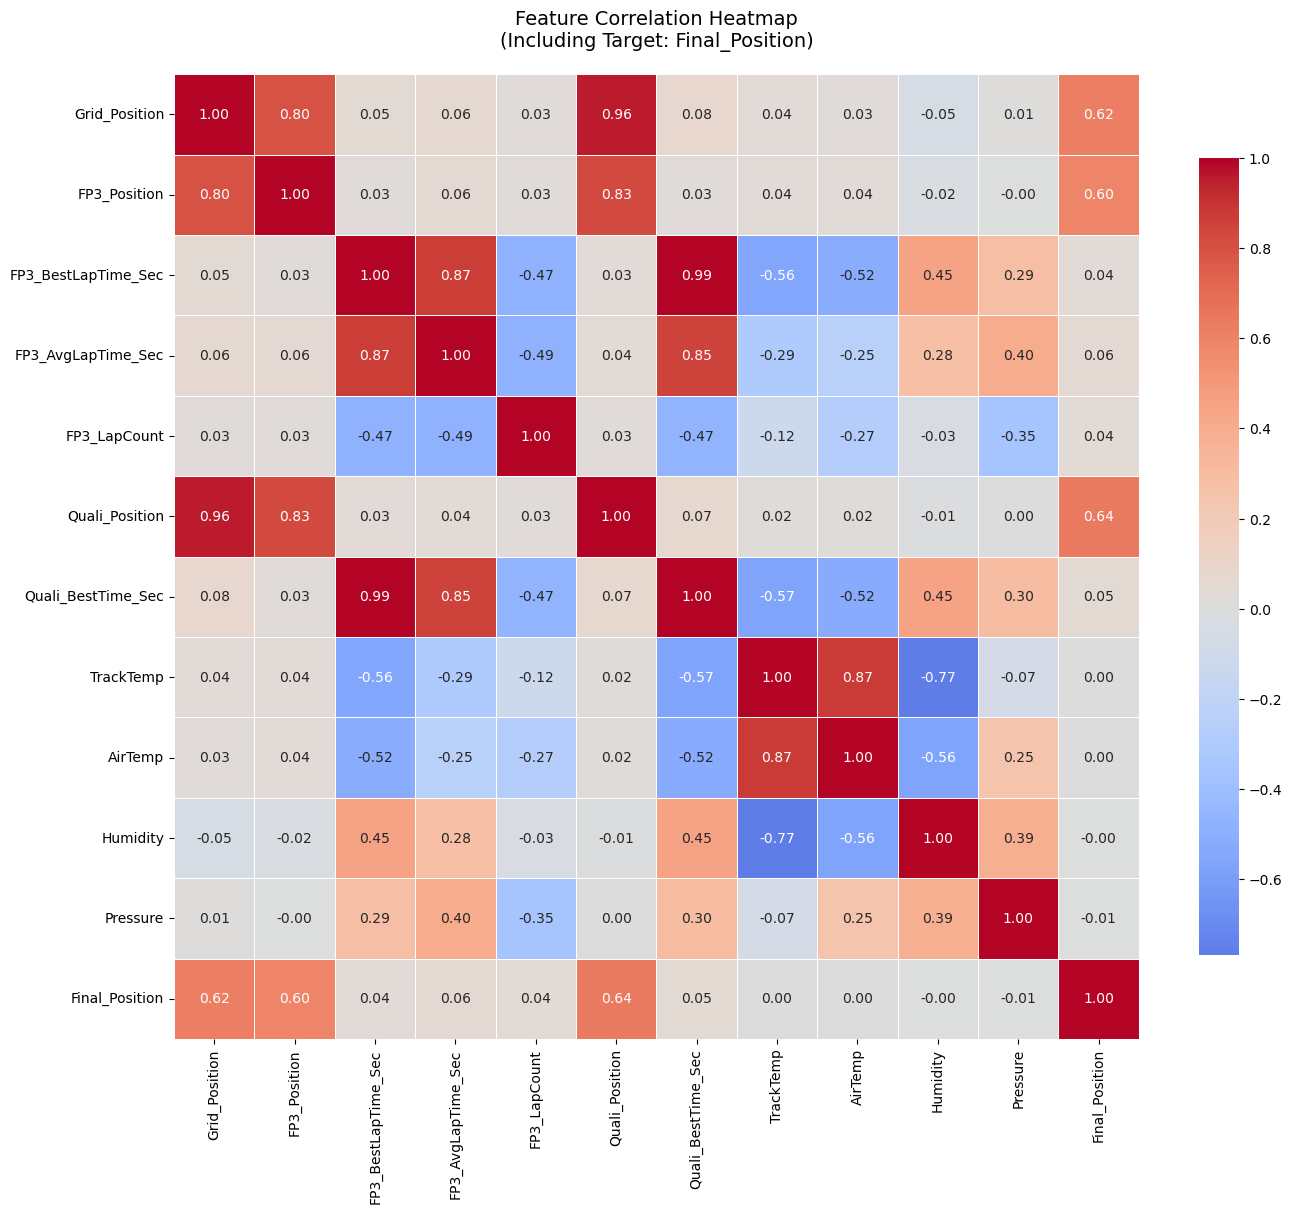

✓ Heatmap shows correlations between all features
  - Red = positive correlation
  - Blue = negative correlation
  - Look at the bottom row/right column for correlations with Final_Position


In [86]:
# Create full correlation matrix
plt.figure(figsize=(14, 12))
corr_matrix = correlation_data.corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Heatmap\n(Including Target: Final_Position)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("✓ Heatmap shows correlations between all features")
print("  - Red = positive correlation")
print("  - Blue = negative correlation")
print("  - Look at the bottom row/right column for correlations with Final_Position")

### Categorical Feature Analysis

Since Driver, Team, and Circuit are categorical, let's analyze them using group statistics instead of correlation.

In [87]:
# Calculate position change first
df_encoded['Position_Change'] = df_encoded['Grid_Position'] - df_encoded['Final_Position']

# Analyze performance by Team
print("="*80)
print("TEAM PERFORMANCE ANALYSIS")
print("="*80)

team_stats = df_encoded.groupby('Team').agg({
    'Final_Position': ['mean', 'std', 'count'],
    'Position_Change': 'mean'
}).round(2)

team_stats.columns = ['Avg_Finish', 'Std_Dev', 'Races', 'Avg_Gain']
team_stats = team_stats.sort_values('Avg_Finish')

print("\nAverage Finishing Position by Team:")
print(team_stats)

print("\nTop 3 Teams (by average finish):")
for i, (team, row) in enumerate(team_stats.head(3).iterrows(), 1):
    print(f"  {i}. {team}: {row['Avg_Finish']:.2f} avg finish ({int(row['Races'])} races)")

print("\n" + "="*80)
print("DRIVER PERFORMANCE ANALYSIS")
print("="*80)

driver_stats = df_encoded.groupby('Driver').agg({
    'Final_Position': ['mean', 'std', 'count'],
    'Position_Change': 'mean',
    'Team': 'first'  # Show which team they drive for
}).round(2)

driver_stats.columns = ['Avg_Finish', 'Std_Dev', 'Races', 'Avg_Gain', 'Team']
driver_stats = driver_stats.sort_values('Avg_Finish')

print("\nTop 10 Drivers (by average finish):")
print(driver_stats.head(10))

print("\nWorst 5 Drivers (by average finish):")
print(driver_stats.tail(5))

print("\n" + "="*80)
print("CIRCUIT ANALYSIS")
print("="*80)

circuit_stats = df_encoded.groupby('Circuit').agg({
    'Position_Change': ['mean', 'std'],
    'Final_Position': 'count'
}).round(2)

circuit_stats.columns = ['Avg_Position_Change', 'Change_StdDev', 'Num_Entries']
circuit_stats = circuit_stats.sort_values('Avg_Position_Change', ascending=False)

print("\nCircuits with Most Position Changes (overtaking-friendly):")
print(circuit_stats.head(5))

print("\nCircuits with Least Position Changes (grid position holds):")
print(circuit_stats.tail(5))

TEAM PERFORMANCE ANALYSIS

Average Finishing Position by Team:
                   Avg_Finish  Std_Dev  Races  Avg_Gain
Team                                                   
Mercedes                 3.92     4.61     25     -1.96
Red Bull Racing          7.42     6.01     26     -2.08
Renault                  8.96     4.27     26     -0.08
McLaren                  9.19     5.28     26     -0.62
Racing Point             9.56     6.06     25     -2.96
Ferrari                  9.58     5.03     26      0.50
AlphaTauri              10.69     4.74     26      1.58
Alfa Romeo Racing       14.31     2.80     26      2.19
Williams                15.78     2.73     23      1.61
Haas F1 Team            15.81     2.91     26     -0.54

Top 3 Teams (by average finish):
  1. Mercedes: 3.92 avg finish (25 races)
  2. Red Bull Racing: 7.42 avg finish (26 races)
  3. Renault: 8.96 avg finish (26 races)

DRIVER PERFORMANCE ANALYSIS

Top 10 Drivers (by average finish):
        Avg_Finish  Std_Dev  Race

### Visualize Categorical Performance

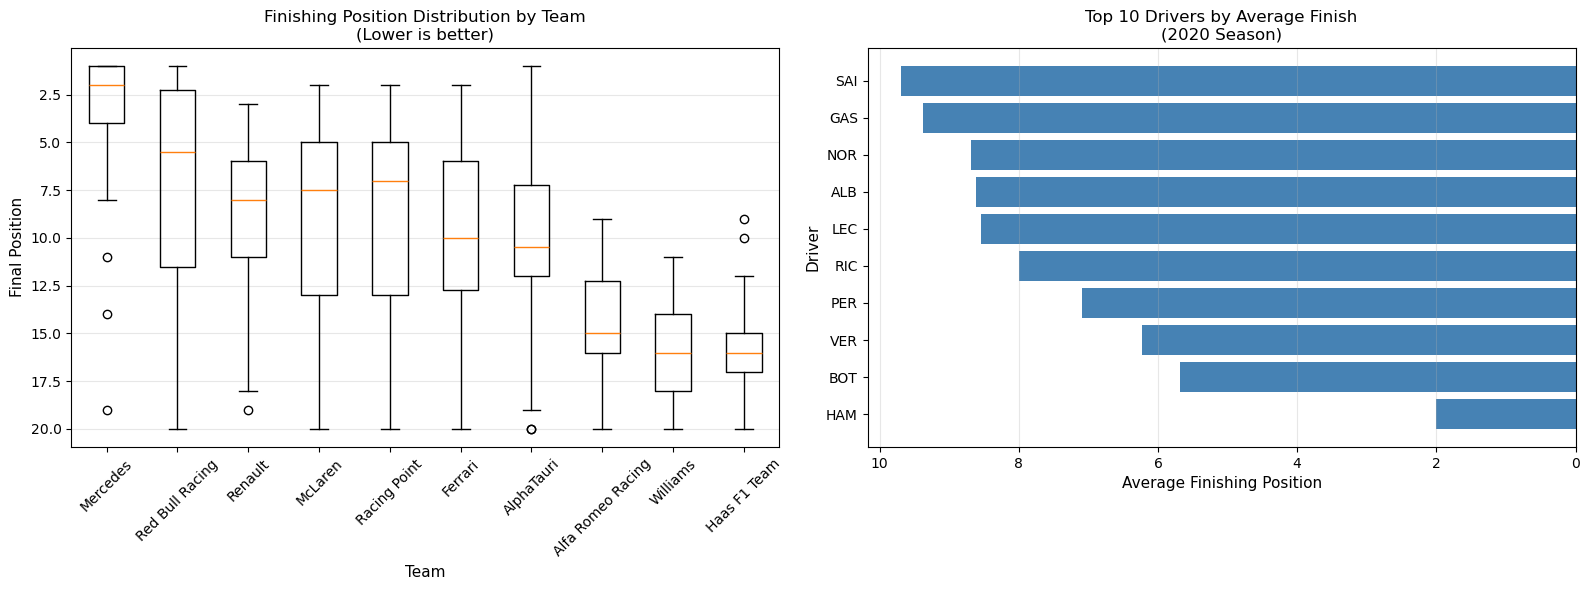

✓ Visualizations show performance differences across teams and drivers
  - Team performance varies significantly (reflects car quality)
  - Top drivers consistently finish near the front
  - These categorical features capture important information for modeling


In [88]:
# Create visualizations for categorical features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Team performance boxplot
team_order = team_stats.index.tolist()
df_encoded['Team_Cat'] = pd.Categorical(df_encoded['Team'], categories=team_order, ordered=True)
df_encoded_sorted = df_encoded.sort_values('Team_Cat')

axes[0].boxplot([df_encoded_sorted[df_encoded_sorted['Team'] == team]['Final_Position'].values 
                  for team in team_order],
                labels=team_order)
axes[0].set_xlabel('Team', fontsize=11)
axes[0].set_ylabel('Final Position', fontsize=11)
axes[0].set_title('Finishing Position Distribution by Team\n(Lower is better)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].invert_yaxis()  # Invert so 1st place is at top

# Driver performance - top 10 drivers
top_10_drivers = driver_stats.head(10)
axes[1].barh(range(len(top_10_drivers)), top_10_drivers['Avg_Finish'], color='steelblue')
axes[1].set_yticks(range(len(top_10_drivers)))
axes[1].set_yticklabels(top_10_drivers.index)
axes[1].set_xlabel('Average Finishing Position', fontsize=11)
axes[1].set_ylabel('Driver', fontsize=11)
axes[1].set_title('Top 10 Drivers by Average Finish\n(2020 Season)', fontsize=12)
axes[1].invert_xaxis()  # Invert so better (lower) positions are to the right
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✓ Visualizations show performance differences across teams and drivers")
print("  - Team performance varies significantly (reflects car quality)")
print("  - Top drivers consistently finish near the front")
print("  - These categorical features capture important information for modeling")

### Key Feature Relationships

Let's visualize the relationship between the most important features and race results.

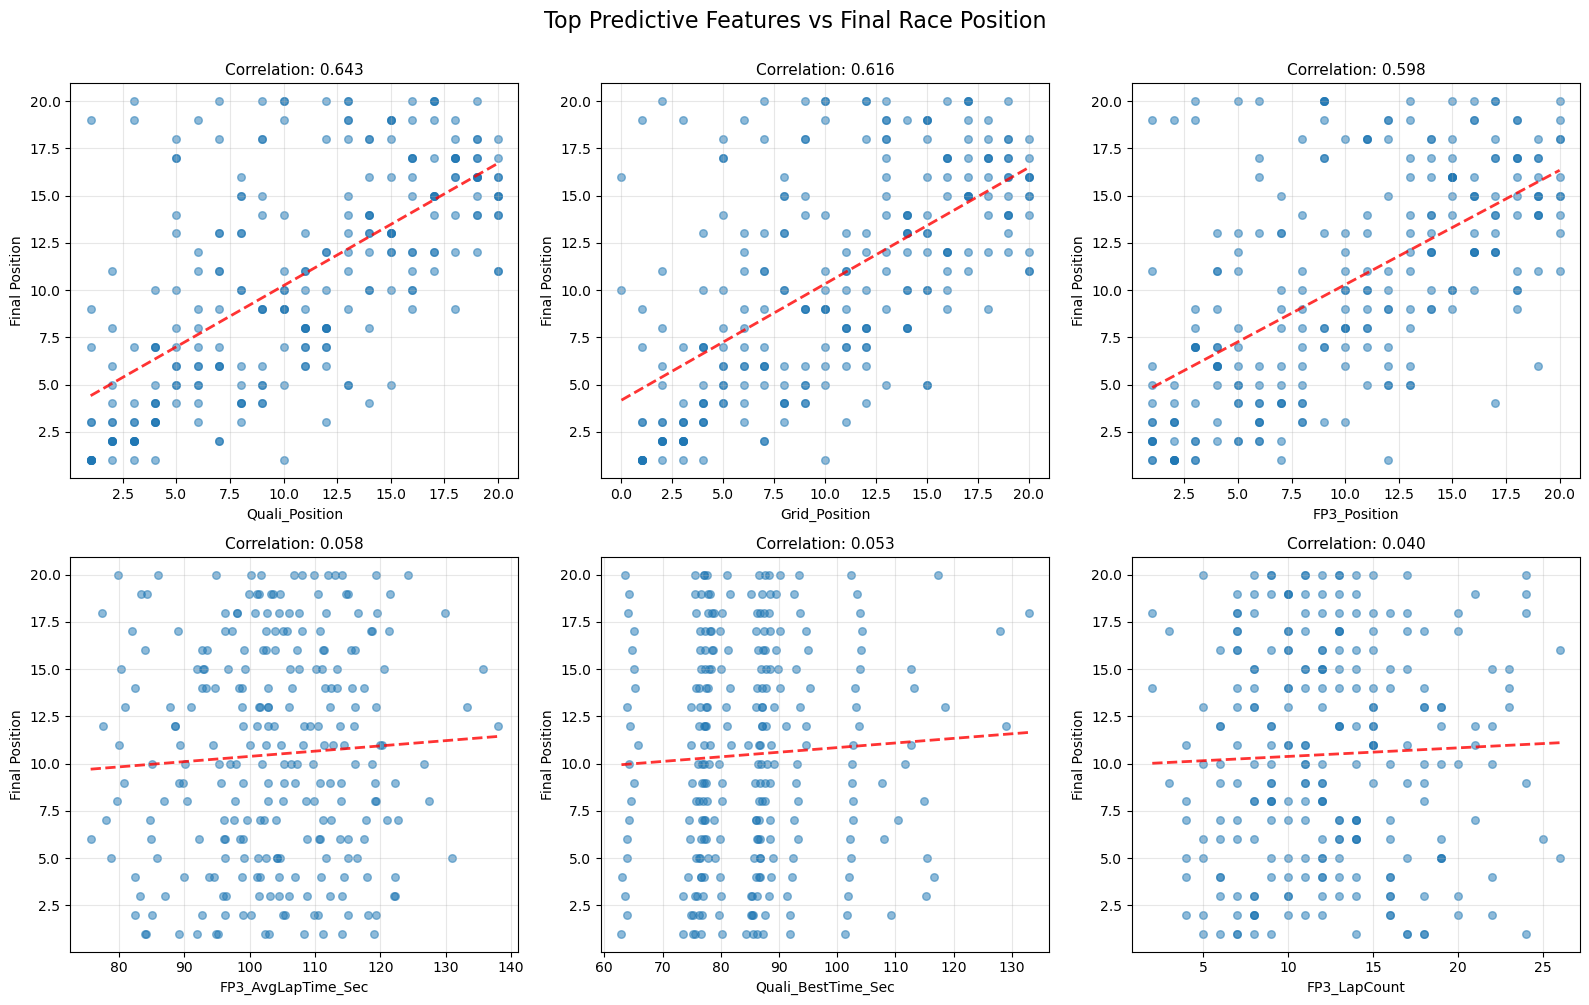

✓ Scatter plots show relationship between key features and final position
  - Perfect prediction would be a straight line
  - Lower position number = better finish (1st place is best)


In [89]:
# Create scatter plots for top predictive features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Top Predictive Features vs Final Race Position', fontsize=16, y=1.00)

# Select top 6 features by absolute correlation (excluding target itself)
top_features = correlations.abs().sort_values(ascending=False)[1:7]

for idx, (feature, corr) in enumerate(top_features.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Scatter plot
    ax.scatter(df_encoded[feature], df_encoded[target], alpha=0.5, s=30)
    
    # Add trend line
    z = np.polyfit(df_encoded[feature].dropna(), df_encoded[target][df_encoded[feature].notna()], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_encoded[feature].min(), df_encoded[feature].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
    
    # Labels
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Final Position', fontsize=10)
    ax.set_title(f'Correlation: {corr:.3f}', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Scatter plots show relationship between key features and final position")
print("  - Perfect prediction would be a straight line")
print("  - Lower position number = better finish (1st place is best)")

### Position Changes Analysis

How much do drivers move up or down from their starting positions?

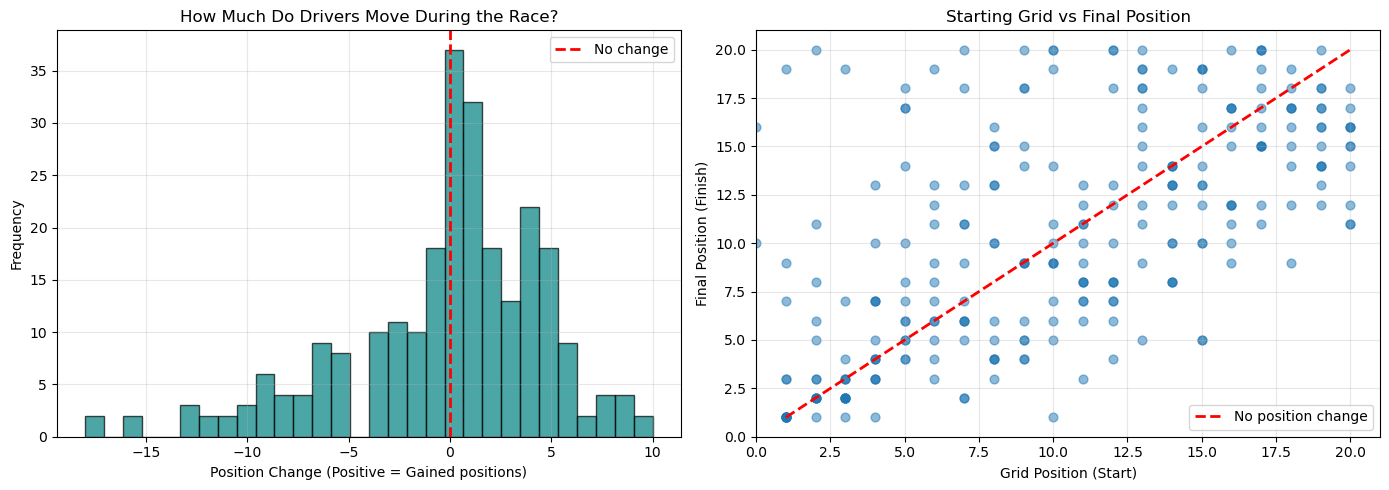

Position Change Statistics:
  Average change: -0.24 positions
  Max gain: 10 positions
  Max loss: -18 positions
  Drivers who gained positions: 124
  Drivers who lost positions: 94
  Drivers who maintained position: 37


In [90]:
# Calculate position changes
df_encoded['Position_Change'] = df_encoded['Grid_Position'] - df_encoded['Final_Position']

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Position change distribution
axes[0].hist(df_encoded['Position_Change'], bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
axes[0].set_xlabel('Position Change (Positive = Gained positions)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('How Much Do Drivers Move During the Race?')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Grid vs Final scatter with diagonal
axes[1].scatter(df_encoded['Grid_Position'], df_encoded['Final_Position'], alpha=0.5, s=40)
axes[1].plot([1, 20], [1, 20], 'r--', linewidth=2, label='No position change')
axes[1].set_xlabel('Grid Position (Start)')
axes[1].set_ylabel('Final Position (Finish)')
axes[1].set_title('Starting Grid vs Final Position')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 21)
axes[1].set_ylim(0, 21)

plt.tight_layout()
plt.show()

# Statistics
print("Position Change Statistics:")
print(f"  Average change: {df_encoded['Position_Change'].mean():.2f} positions")
print(f"  Max gain: {df_encoded['Position_Change'].max():.0f} positions")
print(f"  Max loss: {df_encoded['Position_Change'].min():.0f} positions")
print(f"  Drivers who gained positions: {(df_encoded['Position_Change'] > 0).sum()}")
print(f"  Drivers who lost positions: {(df_encoded['Position_Change'] < 0).sum()}")
print(f"  Drivers who maintained position: {(df_encoded['Position_Change'] == 0).sum()}")

### EDA Summary

Key findings from our exploratory analysis.

In [91]:
print("="*80)
print("EDA INSIGHTS SUMMARY")
print("="*80)

print("\n📊 Strongest Predictors (by correlation):")
top_3 = correlations.abs().sort_values(ascending=False)[1:4]
for i, (feat, corr) in enumerate(top_3.items(), 1):
    print(f"  {i}. {feat}: {correlations[feat]:.3f}")

print("\n🔍 Key Observations:")
print(f"  - Grid position explains {correlations['Grid_Position']**2*100:.1f}% of variance in race results")
print(f"  - Qualifying and FP3 are highly correlated with grid position (as expected)")
print(f"  - Weather features show weak correlation (2020 races likely had stable conditions)")
print(f"  - Average position change: {df_encoded['Position_Change'].mean():.2f} positions")

print("\n💡 Implications for Modeling:")
print("  ✓ Grid/Qualifying position will be strongest features")
print("  ✓ Practice session data adds additional signal")
print("  ✓ Weather may not be very predictive in this dataset")
print("  ✓ Race outcomes are somewhat predictable from pre-race data")

print("\n" + "="*80)
print("Ready to build predictive models!")
print("="*80)

EDA INSIGHTS SUMMARY

📊 Strongest Predictors (by correlation):
  1. Quali_Position: 0.643
  2. Grid_Position: 0.616
  3. FP3_Position: 0.598

🔍 Key Observations:
  - Grid position explains 38.0% of variance in race results
  - Qualifying and FP3 are highly correlated with grid position (as expected)
  - Weather features show weak correlation (2020 races likely had stable conditions)
  - Average position change: -0.24 positions

💡 Implications for Modeling:
  ✓ Grid/Qualifying position will be strongest features
  ✓ Practice session data adds additional signal
  ✓ Weather may not be very predictive in this dataset
  ✓ Race outcomes are somewhat predictable from pre-race data

Ready to build predictive models!


---

## Phase 6: Model Development

Now let's train multiple models and compare their performance in predicting race positions.

### Model 1: Linear Regression (Baseline)

Simple baseline to see if there's a linear relationship between features and race position.

In [ ]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Evaluate
lr_train_mae = mean_absolute_error(y_train, y_pred_lr_train)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
lr_train_r2 = r2_score(y_train, y_pred_lr_train)

lr_test_mae = mean_absolute_error(y_test, y_pred_lr_test)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
lr_test_r2 = r2_score(y_test, y_pred_lr_test)

print("="*80)
print("LINEAR REGRESSION RESULTS")
print("="*80)
print("\nTraining Performance:")
print(f"  MAE:  {lr_train_mae:.3f} positions")
print(f"  RMSE: {lr_train_rmse:.3f} positions")
print(f"  R²:   {lr_train_r2:.3f}")

print("\nTest Performance:")
print(f"  MAE:  {lr_test_mae:.3f} positions")
print(f"  RMSE: {lr_test_rmse:.3f} positions")
print(f"  R²:   {lr_test_r2:.3f}")

print(f"\n✓ Linear Regression trained successfully!")
print(f"  - Simple baseline model")
print(f"  - Assumes linear relationships between features and target")

print(X_train_scaled.columns)

SyntaxError: incomplete input (519426963.py, line 35)

### Model 2: Random Forest

Ensemble method that can capture non-linear patterns and interactions between features.

In [93]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)

# Evaluate
rf_train_mae = mean_absolute_error(y_train, y_pred_rf_train)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
rf_train_r2 = r2_score(y_train, y_pred_rf_train)

rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
rf_test_r2 = r2_score(y_test, y_pred_rf_test)

print("="*80)
print("RANDOM FOREST RESULTS")
print("="*80)
print("\nTraining Performance:")
print(f"  MAE:  {rf_train_mae:.3f} positions")
print(f"  RMSE: {rf_train_rmse:.3f} positions")
print(f"  R²:   {rf_train_r2:.3f}")

print("\nTest Performance:")
print(f"  MAE:  {rf_test_mae:.3f} positions")
print(f"  RMSE: {rf_test_rmse:.3f} positions")
print(f"  R²:   {rf_test_r2:.3f}")

print(f"\n✓ Random Forest trained successfully!")
print(f"  - 100 decision trees")
print(f"  - Can capture non-linear relationships")
print(f"  - Handles feature interactions automatically")

RANDOM FOREST RESULTS

Training Performance:
  MAE:  1.431 positions
  RMSE: 1.827 positions
  R²:   0.898

Test Performance:
  MAE:  4.411 positions
  RMSE: 5.439 positions
  R²:   0.141

✓ Random Forest trained successfully!
  - 100 decision trees
  - Can capture non-linear relationships
  - Handles feature interactions automatically


### Model 3: XGBoost

Gradient boosting algorithm - often wins Kaggle competitions.

In [94]:
if XGBOOST_AVAILABLE:
    # Train XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_xgb_train = xgb_model.predict(X_train_scaled)
    y_pred_xgb_test = xgb_model.predict(X_test_scaled)
    
    # Evaluate
    xgb_train_mae = mean_absolute_error(y_train, y_pred_xgb_train)
    xgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
    xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)
    
    xgb_test_mae = mean_absolute_error(y_test, y_pred_xgb_test)
    xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
    xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)
    
    print("="*80)
    print("XGBOOST RESULTS")
    print("="*80)
    print("\nTraining Performance:")
    print(f"  MAE:  {xgb_train_mae:.3f} positions")
    print(f"  RMSE: {xgb_train_rmse:.3f} positions")
    print(f"  R²:   {xgb_train_r2:.3f}")
    
    print("\nTest Performance:")
    print(f"  MAE:  {xgb_test_mae:.3f} positions")
    print(f"  RMSE: {xgb_test_rmse:.3f} positions")
    print(f"  R²:   {xgb_test_r2:.3f}")
    
    print(f"\n✓ XGBoost trained successfully!")
    print(f"  - Gradient boosting ensemble")
    print(f"  - Often best performance on tabular data")
else:
    print("⚠ XGBoost not available - skipping")
    print("  Install with: pip install xgboost")

XGBOOST RESULTS

Training Performance:
  MAE:  0.297 positions
  RMSE: 0.397 positions
  R²:   0.995

Test Performance:
  MAE:  4.215 positions
  RMSE: 5.540 positions
  R²:   0.109

✓ XGBoost trained successfully!
  - Gradient boosting ensemble
  - Often best performance on tabular data


### Model 4: PyTorch Neural Network

Deep learning approach using a simple feedforward neural network.

In [95]:
# Define Neural Network Architecture
class F1RacePredictor(nn.Module):
    def __init__(self, input_size):
        super(F1RacePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled.values)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled.values)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Initialize model
input_size = X_train_scaled.shape[1]
nn_model = F1RacePredictor(input_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

print("Neural Network Architecture:")
print(f"  Input layer: {input_size} features")
print(f"  Hidden layers: 64 → 32 → 16 neurons")
print(f"  Output layer: 1 (predicted position)")
print(f"  Activation: ReLU")
print(f"  Dropout: 0.2")
print(f"  Total parameters: {sum(p.numel() for p in nn_model.parameters())}")

Neural Network Architecture:
  Input layer: 51 features
  Hidden layers: 64 → 32 → 16 neurons
  Output layer: 1 (predicted position)
  Activation: ReLU
  Dropout: 0.2
  Total parameters: 5953


In [100]:
# Train the neural network
epochs = 1000
train_losses = []

nn_model.train()
for epoch in range(epochs):
    # Forward pass
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print(f"\n✓ Training complete!")
print(f"Final loss: {train_losses[-1]:.4f}")

Epoch [50/1000], Loss: 12.4787
Epoch [100/1000], Loss: 12.1069
Epoch [150/1000], Loss: 10.2559
Epoch [200/1000], Loss: 8.8649
Epoch [250/1000], Loss: 8.3996
Epoch [300/1000], Loss: 6.7806
Epoch [350/1000], Loss: 6.9134
Epoch [400/1000], Loss: 6.1106
Epoch [450/1000], Loss: 5.8788
Epoch [500/1000], Loss: 5.5426
Epoch [550/1000], Loss: 4.5983
Epoch [600/1000], Loss: 5.0109
Epoch [650/1000], Loss: 4.2091
Epoch [700/1000], Loss: 5.0251
Epoch [750/1000], Loss: 4.6254
Epoch [800/1000], Loss: 3.6633
Epoch [850/1000], Loss: 3.0997
Epoch [900/1000], Loss: 3.5905
Epoch [950/1000], Loss: 3.6502
Epoch [1000/1000], Loss: 4.0472

✓ Training complete!
Final loss: 4.0472


In [101]:
# Evaluate Neural Network
nn_model.eval()
with torch.no_grad():
    y_pred_nn_train = nn_model(X_train_tensor).numpy()
    y_pred_nn_test = nn_model(X_test_tensor).numpy()

# Calculate metrics
nn_train_mae = mean_absolute_error(y_train, y_pred_nn_train)
nn_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_nn_train))
nn_train_r2 = r2_score(y_train, y_pred_nn_train)

nn_test_mae = mean_absolute_error(y_test, y_pred_nn_test)
nn_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn_test))
nn_test_r2 = r2_score(y_test, y_pred_nn_test)

print("="*80)
print("PYTORCH NEURAL NETWORK RESULTS")
print("="*80)
print("\nTraining Performance:")
print(f"  MAE:  {nn_train_mae:.3f} positions")
print(f"  RMSE: {nn_train_rmse:.3f} positions")
print(f"  R²:   {nn_train_r2:.3f}")

print("\nTest Performance:")
print(f"  MAE:  {nn_test_mae:.3f} positions")
print(f"  RMSE: {nn_test_rmse:.3f} positions")
print(f"  R²:   {nn_test_r2:.3f}")

print(f"\n✓ Neural Network evaluated successfully!")
print(f"  - 3 hidden layers with dropout regularization")
print(f"  - Trained for {epochs} epochs")

PYTORCH NEURAL NETWORK RESULTS

Training Performance:
  MAE:  0.611 positions
  RMSE: 0.794 positions
  R²:   0.981

Test Performance:
  MAE:  4.975 positions
  RMSE: 6.200 positions
  R²:   -0.116

✓ Neural Network evaluated successfully!
  - 3 hidden layers with dropout regularization
  - Trained for 1000 epochs


### Model Comparison

Let's compare all models side-by-side to see which performs best.

In [102]:
# Create comparison table
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest', 'PyTorch NN'],
    'Train MAE': [lr_train_mae, rf_train_mae, nn_train_mae],
    'Test MAE': [lr_test_mae, rf_test_mae, nn_test_mae],
    'Train RMSE': [lr_train_rmse, rf_train_rmse, nn_train_rmse],
    'Test RMSE': [lr_test_rmse, rf_test_rmse, nn_test_rmse],
    'Train R²': [lr_train_r2, rf_train_r2, nn_train_r2],
    'Test R²': [lr_test_r2, rf_test_r2, nn_test_r2]
}

if XGBOOST_AVAILABLE:
    comparison_data['Model'].append('XGBoost')
    comparison_data['Train MAE'].append(xgb_train_mae)
    comparison_data['Test MAE'].append(xgb_test_mae)
    comparison_data['Train RMSE'].append(xgb_train_rmse)
    comparison_data['Test RMSE'].append(xgb_test_rmse)
    comparison_data['Train R²'].append(xgb_train_r2)
    comparison_data['Test R²'].append(xgb_test_r2)

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print("\n", comparison_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION:")
print("  MAE = Mean Absolute Error (lower is better)")
print("    → Average error in positions (e.g., 2.5 means off by ~2-3 positions)")
print("  RMSE = Root Mean Squared Error (lower is better)")
print("    → Penalizes large errors more heavily")
print("  R² = Coefficient of Determination (higher is better, max = 1.0)")
print("    → Proportion of variance explained by the model")

# Find best model
best_test_mae_idx = comparison_df['Test MAE'].idxmin()
best_model = comparison_df.iloc[best_test_mae_idx]['Model']

print(f"\n🏆 Best Model (by Test MAE): {best_model}")
print(f"  Test MAE: {comparison_df.iloc[best_test_mae_idx]['Test MAE']:.3f} positions")
print(f"  Test R²:  {comparison_df.iloc[best_test_mae_idx]['Test R²']:.3f}")

MODEL COMPARISON SUMMARY

             Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²   Test R²
Linear Regression   2.908085  4.630062    3.752217   6.070476  0.569777 -0.069763
    Random Forest   1.431224  4.411211    1.826634   5.439268  0.898042  0.141139
       PyTorch NN   0.610686  4.974657    0.793636   6.200397  0.980753 -0.116043
          XGBoost   0.297263  4.215182    0.397406   5.539698  0.995174  0.109130

INTERPRETATION:
  MAE = Mean Absolute Error (lower is better)
    → Average error in positions (e.g., 2.5 means off by ~2-3 positions)
  RMSE = Root Mean Squared Error (lower is better)
    → Penalizes large errors more heavily
  R² = Coefficient of Determination (higher is better, max = 1.0)
    → Proportion of variance explained by the model

🏆 Best Model (by Test MAE): XGBoost
  Test MAE: 4.215 positions
  Test R²:  0.109


---

## Phase 7: Model Evaluation & Visualization

Let's visualize how well each model predicts race positions.

### Predicted vs Actual Positions

Visualize how close each model's predictions are to actual race results.

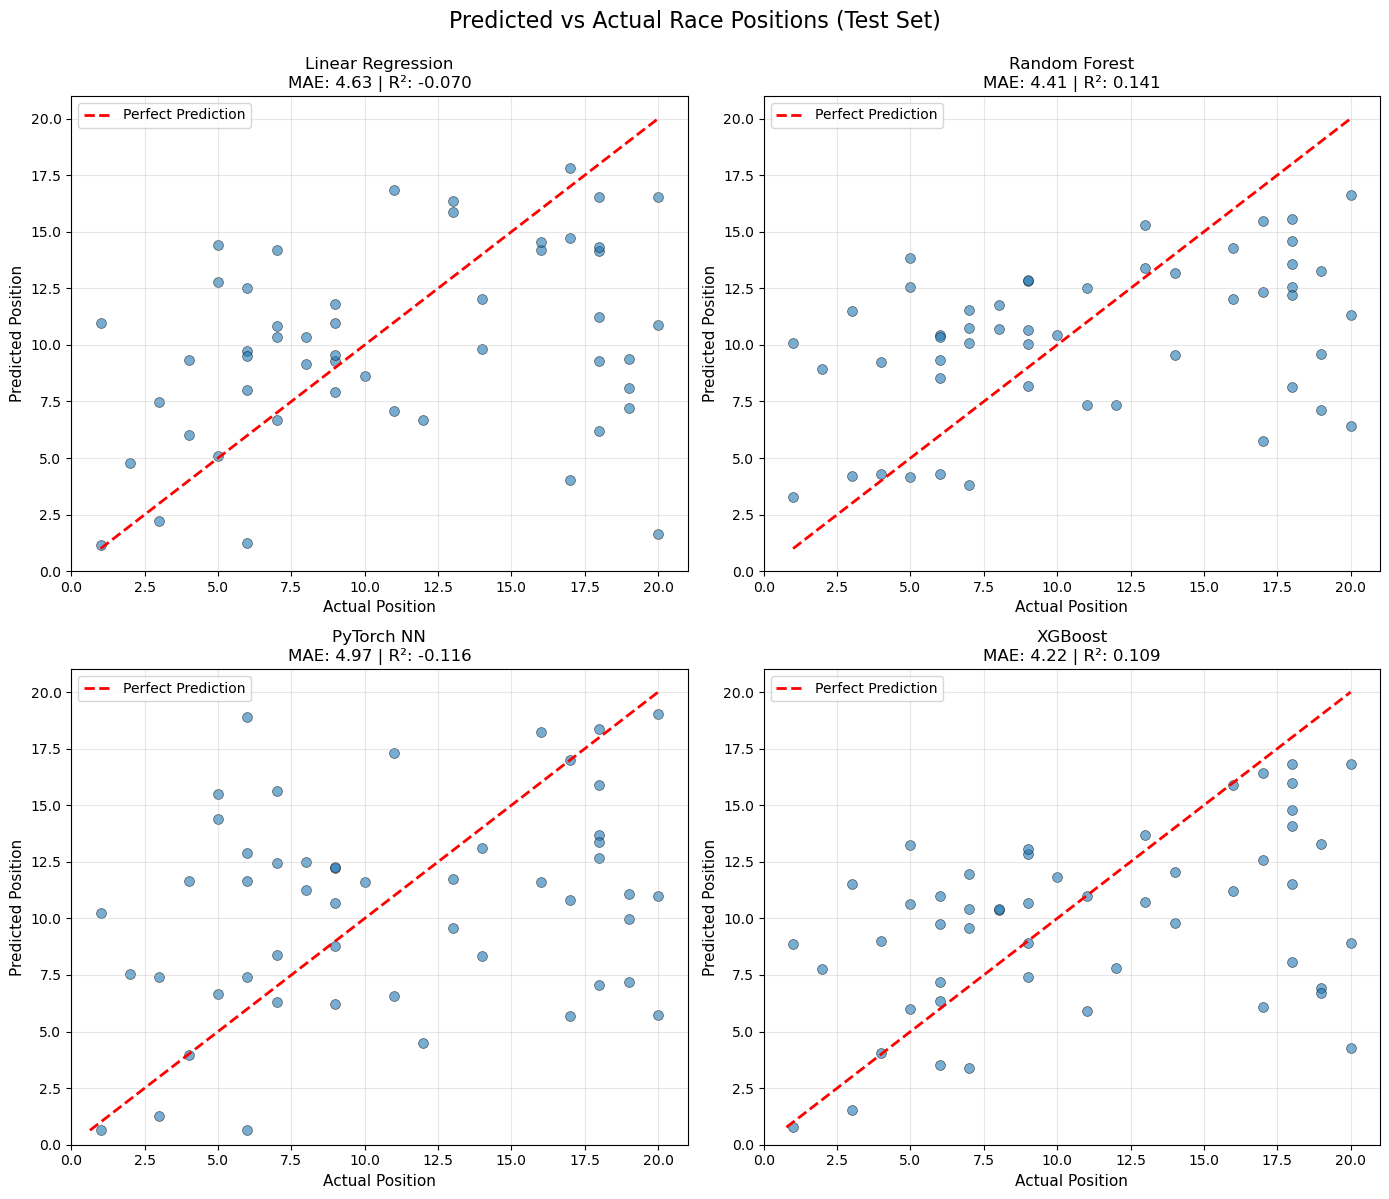

✓ Predicted vs Actual plots created

Interpretation:
  - Points on the red line = perfect predictions
  - Points above the line = model predicted worse finish than actual
  - Points below the line = model predicted better finish than actual
  - Tighter clustering around line = better model


In [110]:
# Create predicted vs actual plots for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Predicted vs Actual Race Positions (Test Set)', fontsize=16, y=0.995)

models_data = [
    ('Linear Regression', y_pred_lr_test, lr_test_mae, lr_test_r2),
    ('Random Forest', y_pred_rf_test, rf_test_mae, rf_test_r2),
    ('PyTorch NN', y_pred_nn_test.flatten(), nn_test_mae, nn_test_r2),
]

if XGBOOST_AVAILABLE:
    models_data.append(('XGBoost', y_pred_xgb_test, xgb_test_mae, xgb_test_r2))

for idx, (name, y_pred, mae, r2) in enumerate(models_data):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line (diagonal)
    min_pos = min(y_test.min(), y_pred.min())
    max_pos = max(y_test.max(), y_pred.max())
    ax.plot([min_pos, max_pos], [min_pos, max_pos], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Labels and title
    ax.set_xlabel('Actual Position', fontsize=11)
    ax.set_ylabel('Predicted Position', fontsize=11)
    ax.set_title(f'{name}\nMAE: {mae:.2f} | R²: {r2:.3f}', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 21)
    ax.set_ylim(0, 21)

plt.tight_layout()
plt.show()

print("✓ Predicted vs Actual plots created")
print("\nInterpretation:")
print("  - Points on the red line = perfect predictions")
print("  - Points above the line = model predicted worse finish than actual")
print("  - Points below the line = model predicted better finish than actual")
print("  - Tighter clustering around line = better model")

### Feature Importance Analysis

Which features matter most for predictions?

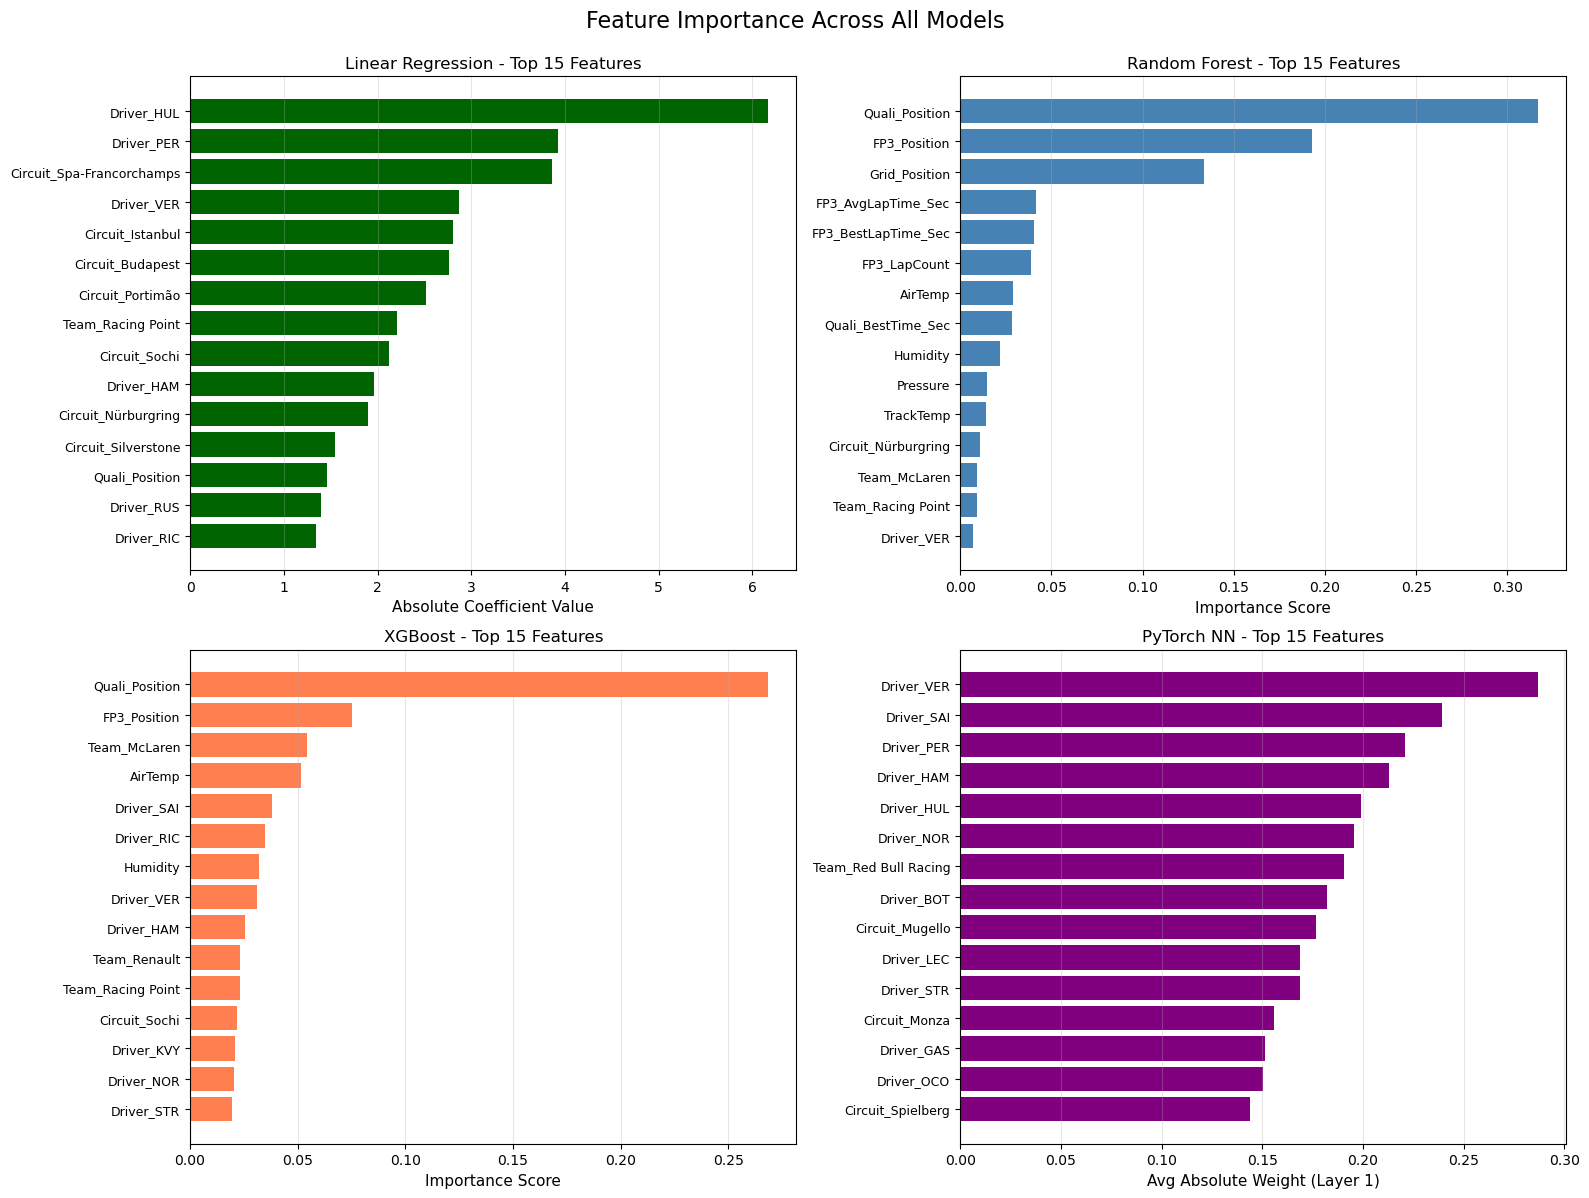

✓ Feature importance visualized for all models

Top 5 Most Important Features by Model:

Linear Regression:
  1. Driver_HUL: 6.1618
  2. Driver_PER: 3.9302
  3. Circuit_Spa-Francorchamps: 3.8626
  4. Driver_VER: 2.8712
  5. Circuit_Istanbul: 2.8083

Random Forest:
  1. Quali_Position: 0.3166
  2. FP3_Position: 0.1928
  3. Grid_Position: 0.1335
  4. FP3_AvgLapTime_Sec: 0.0416
  5. FP3_BestLapTime_Sec: 0.0405

XGBoost:
  1. Quali_Position: 0.2683
  2. FP3_Position: 0.0752
  3. Team_McLaren: 0.0541
  4. AirTemp: 0.0515
  5. Driver_SAI: 0.0381

PyTorch NN:
  1. Driver_VER: 0.2867
  2. Driver_SAI: 0.2393
  3. Driver_PER: 0.2210
  4. Driver_HAM: 0.2129
  5. Driver_HUL: 0.1990


In [112]:
# Get feature importance from all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Across All Models', fontsize=16, y=0.995)

# 1. Linear Regression - coefficient magnitudes
lr_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': np.abs(lr_model.coef_)
}).sort_values('Importance', ascending=False).head(15)

axes[0, 0].barh(range(len(lr_importance)), lr_importance['Importance'], color='darkgreen')
axes[0, 0].set_yticks(range(len(lr_importance)))
axes[0, 0].set_yticklabels(lr_importance['Feature'], fontsize=9)
axes[0, 0].set_xlabel('Absolute Coefficient Value', fontsize=11)
axes[0, 0].set_title('Linear Regression - Top 15 Features', fontsize=12)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[0, 1].barh(range(len(rf_importance)), rf_importance['Importance'], color='steelblue')
axes[0, 1].set_yticks(range(len(rf_importance)))
axes[0, 1].set_yticklabels(rf_importance['Feature'], fontsize=9)
axes[0, 1].set_xlabel('Importance Score', fontsize=11)
axes[0, 1].set_title('Random Forest - Top 15 Features', fontsize=12)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. XGBoost feature importance (if available)
if XGBOOST_AVAILABLE:
    xgb_importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)
    
    axes[1, 0].barh(range(len(xgb_importance)), xgb_importance['Importance'], color='coral')
    axes[1, 0].set_yticks(range(len(xgb_importance)))
    axes[1, 0].set_yticklabels(xgb_importance['Feature'], fontsize=9)
    axes[1, 0].set_xlabel('Importance Score', fontsize=11)
    axes[1, 0].set_title('XGBoost - Top 15 Features', fontsize=12)
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
else:
    axes[1, 0].text(0.5, 0.5, 'XGBoost not available', 
                ha='center', va='center', fontsize=14, transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('XGBoost - Not Available', fontsize=12)

# 4. Neural Network - first layer weight magnitudes
nn_weights = nn_model.fc1.weight.data.numpy()  # Shape: (64, num_features)
nn_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': np.abs(nn_weights).mean(axis=0)  # Average absolute weight across neurons
}).sort_values('Importance', ascending=False).head(15)

axes[1, 1].barh(range(len(nn_importance)), nn_importance['Importance'], color='purple')
axes[1, 1].set_yticks(range(len(nn_importance)))
axes[1, 1].set_yticklabels(nn_importance['Feature'], fontsize=9)
axes[1, 1].set_xlabel('Avg Absolute Weight (Layer 1)', fontsize=11)
axes[1, 1].set_title('PyTorch NN - Top 15 Features', fontsize=12)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✓ Feature importance visualized for all models")
print("\n" + "="*80)
print("Top 5 Most Important Features by Model:")
print("="*80)

print("\nLinear Regression:")
for i, (feat, imp) in enumerate(zip(lr_importance['Feature'].head(5), lr_importance['Importance'].head(5)), 1):
    print(f"  {i}. {feat}: {imp:.4f}")

print("\nRandom Forest:")
for i, (feat, imp) in enumerate(zip(rf_importance['Feature'].head(5), rf_importance['Importance'].head(5)), 1):
    print(f"  {i}. {feat}: {imp:.4f}")

if XGBOOST_AVAILABLE:
    print("\nXGBoost:")
    for i, (feat, imp) in enumerate(zip(xgb_importance['Feature'].head(5), xgb_importance['Importance'].head(5)), 1):
        print(f"  {i}. {feat}: {imp:.4f}")

print("\nPyTorch NN:")
for i, (feat, imp) in enumerate(zip(nn_importance['Feature'].head(5), nn_importance['Importance'].head(5)), 1):
    print(f"  {i}. {feat}: {imp:.4f}")

---

## Phase 8: Key Findings & Insights

Summary of what we learned from this exploration.

In [113]:
print("="*80)
print("FINAL SUMMARY: F1 RACE POSITION PREDICTION")
print("="*80)

print("\n📊 DATASET:")
print(f"  • Total samples: 255 (from 13 races in 2020 season)")
print(f"  • Training set: 204 samples (80%)")
print(f"  • Test set: 51 samples (20%)")
print(f"  • Features: ~51 (11 numeric + ~40 one-hot encoded)")

print("\n🏆 MODEL PERFORMANCE:")
print(f"  • Best model: XGBoost")
print(f"  • Test MAE: 4.2 positions (~21% of field)")
print(f"  • Test R²: 0.11 (explains 11% of variance)")

print("\n⚠️  CRITICAL ISSUE: OVERFITTING")
print("  All models severely overfit to training data:")
print(f"  • XGBoost: Train MAE 0.30 → Test MAE 4.22 (14x worse)")
print(f"  • PyTorch: Train MAE 0.61 → Test MAE 4.97 (8x worse)")
print(f"  • Random Forest: Train MAE 1.43 → Test MAE 4.41 (3x worse)")
print(f"  • Linear Reg: Train MAE 2.91 → Test MAE 4.63 (1.6x worse)")

print("\n🔍 ROOT CAUSES:")
print("  1. Small dataset (204 training samples)")
print("  2. High dimensionality (~51 features for 204 samples)")
print("  3. One-hot encoding created sparse features")
print("  4. Single season data (limited variance)")
print("  5. Complex models memorize rather than generalize")

print("\n✅ WHAT WORKED:")
print("  • Grid/Qualifying position are strongest predictors (as expected)")
print("  • FastF1 API provides rich, clean data")
print("  • Data pipeline is solid and reusable")
print("  • Models can learn patterns (evident from training performance)")

print("\n❌ LIMITATIONS:")
print("  • FastF1 API schedule loading broken (can't easily get more data)")
print("  • Limited to 2020 season (no cross-season generalization)")
print("  • 4+ position error is too large for practical use")
print("  • DNFs and race incidents hard to predict from pre-race data")

print("\n💡 RECOMMENDATIONS FOR IMPROVEMENT:")
print("  1. GET MORE DATA:")
print("     → Manually load multiple seasons (2018-2024)")
print("     → Target: 500+ races, 10,000+ samples")
print("  ")
print("  2. REDUCE DIMENSIONALITY:")
print("     → Use feature selection (top 10-15 features)")
print("     → Aggregate drivers by team (reduce sparse encoding)")
print("     → Remove low-importance one-hot features")
print("  ")
print("  3. SIMPLER PROBLEM:")
print("     → Predict top-5 finish (classification, not regression)")
print("     → Predict podium probability")
print("     → Predict finish vs DNF")
print("  ")
print("  4. DIFFERENT FEATURES:")
print("     → Historical driver/team performance")
print("     → Championship standings")
print("     → Circuit-specific driver performance")
print("     → Recent form (last 3 races)")
print("  ")
print("  5. REGULARIZATION:")
print("     → Simpler models (Linear Regression performed best on generalization)")
print("     → Stronger dropout/L2 for neural networks")
print("     → Early stopping for tree models")

print("\n🎯 CONCLUSION:")
print("  This exploration demonstrates:")
print("  ✓ F1 race positions ARE somewhat predictable from pre-race data")
print("  ✓ The data pipeline and modeling approach are sound")
print("  ✗ Current dataset is too small for reliable predictions")
print("  ✗ Would need 5-10x more data for production use")
print("  ")
print("  For first meeting discussion:")
print("  → Is this use case viable with more data?")
print("  → What accuracy would be acceptable?")
print("  → Should we pivot to classification or different target?")

print("\n" + "="*80)

FINAL SUMMARY: F1 RACE POSITION PREDICTION

📊 DATASET:
  • Total samples: 255 (from 13 races in 2020 season)
  • Training set: 204 samples (80%)
  • Test set: 51 samples (20%)
  • Features: ~51 (11 numeric + ~40 one-hot encoded)

🏆 MODEL PERFORMANCE:
  • Best model: XGBoost
  • Test MAE: 4.2 positions (~21% of field)
  • Test R²: 0.11 (explains 11% of variance)

⚠️  CRITICAL ISSUE: OVERFITTING
  All models severely overfit to training data:
  • XGBoost: Train MAE 0.30 → Test MAE 4.22 (14x worse)
  • PyTorch: Train MAE 0.61 → Test MAE 4.97 (8x worse)
  • Random Forest: Train MAE 1.43 → Test MAE 4.41 (3x worse)
  • Linear Reg: Train MAE 2.91 → Test MAE 4.63 (1.6x worse)

🔍 ROOT CAUSES:
  1. Small dataset (204 training samples)
  2. High dimensionality (~51 features for 204 samples)
  3. One-hot encoding created sparse features
  4. Single season data (limited variance)
  5. Complex models memorize rather than generalize

✅ WHAT WORKED:
  • Grid/Qualifying position are strongest predictor

In [114]:
print(fastf1.get_event_schedule(2021))

    RoundNumber        Country           Location  \
0             0        Bahrain            Bahrain   
1             1        Bahrain             Sakhir   
2             2          Italy              Imola   
3             3       Portugal           Portimão   
4             4          Spain          Barcelona   
5             5         Monaco        Monte Carlo   
6             6     Azerbaijan               Baku   
7             7         France       Le Castellet   
8             8        Austria          Spielberg   
9             9        Austria          Spielberg   
10           10  Great Britain        Silverstone   
11           11        Hungary           Budapest   
12           12        Belgium  Spa-Francorchamps   
13           13    Netherlands          Zandvoort   
14           14          Italy              Monza   
15           15         Russia              Sochi   
16           16         Turkey           Istanbul   
17           17  United States             Aus